In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from datetime import datetime

In [2]:
# Step 1: Download Financial Data (e.g., BTC-USD)
start_date = '2010-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
data = yf.download('USDINR=X', start=start_date, end=end_date)
data = data[['Close']]  
data.dropna(inplace=True)

[*********************100%%**********************]  1 of 1 completed
C:\Users\admin\AppData\Local\Temp\ipykernel_5868\1305640192.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [3]:
# Step 1: Check for stationarity using the Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print('Data is non-stationary, differencing needed.')
    else:
        print('Data is stationary.')

adf_test(data)

ADF Statistic: -0.9353771460009811
p-value: 0.7760991378937874
Data is non-stationary, differencing needed.


In [4]:
# Step 2: Differencing if necessary (if p-value > 0.05)
data_diff = data.diff().dropna()

# Check stationarity again after differencing
adf_test(data_diff)

ADF Statistic: -17.450103091011133
p-value: 4.657858586156492e-30
Data is stationary.


In [5]:
# Step 3: Fit ARIMA model
# We will use ARIMA(p,d,q) model, where d is the differencing order
# We'll select parameters (p=5, d=1, q=0) after evaluating the autocorrelation and partial autocorrelation plots

train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

model = ARIMA(data, order=(5, 1, 0))  # ARIMA(5,1,0)
model_fit = model.fit()

C:\Users\admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [6]:
# Step 3: Predict on the test set
# Generate predictions for the test set
start = len(train)
end = len(train) + len(test) - 1
test_predictions = model_fit.predict(start=start, end=end, typ='levels')

test_predictions

Date
2021-12-03    75.025320
2021-12-06    75.014815
2021-12-07    75.192251
2021-12-08    75.360383
2021-12-09    75.397222
                ...    
2024-11-19    84.476567
2024-11-20    84.412491
2024-11-21    84.400535
2024-11-22    84.389859
2024-11-25    84.467794
Name: predicted_mean, Length: 777, dtype: float64

In [7]:
# Step 4: Evaluate model performance
# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(test, test_predictions)
mae = mean_absolute_error(test, test_predictions)
r2 = r2_score(test, test_predictions)

print(f"MSE: {mse}, MAE: {mae}, R²: {r2}")

MSE: 0.048741791215578936, MAE: 0.1390366400537016, R²: 0.9939852537613071


In [8]:
# Generate future forecast
future_forecast = model_fit.forecast(steps=15)

# Create corresponding date range for the future forecast
future_forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=15, freq='B')

C:\Users\admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [9]:
future_forecast

3882    84.441264
3883    84.438340
3884    84.441031
3885    84.444674
3886    84.441568
3887    84.442268
3888    84.441997
3889    84.442299
3890    84.442355
3891    84.442208
3892    84.442258
3893    84.442241
3894    84.442262
3895    84.442258
3896    84.442252
Name: predicted_mean, dtype: float64

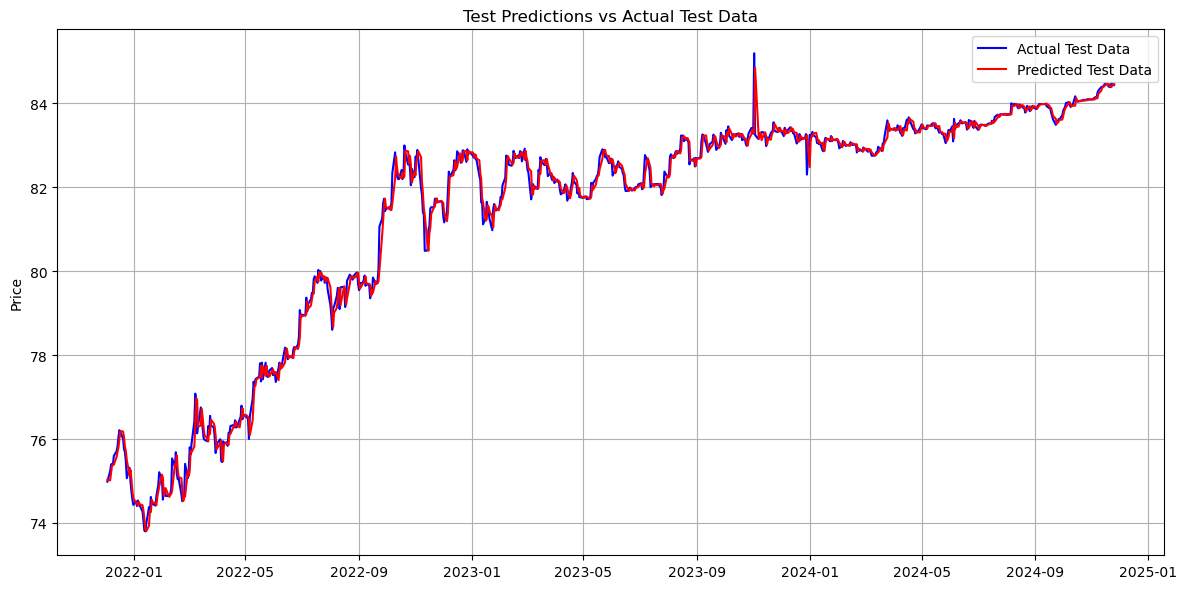

In [10]:
# Plot 1: Test Predictions vs Actual Test Data
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, color='blue', label='Actual Test Data')
plt.plot(test.index, test_predictions, color='red', label='Predicted Test Data')
plt.title('Test Predictions vs Actual Test Data')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

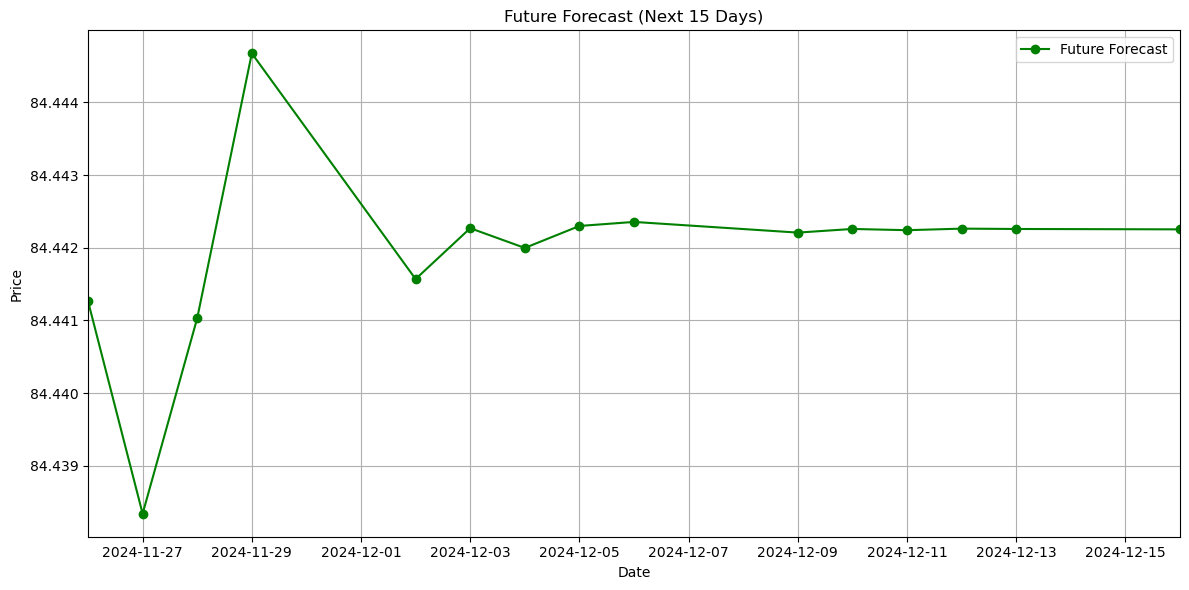

In [11]:
# Plot 2: Future Forecast
plt.figure(figsize=(12, 6))
plt.plot(future_forecast_index, future_forecast, marker = 'o', color='green', label='Future Forecast')
plt.title('Future Forecast (Next 15 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.xlim([future_forecast_index[0], future_forecast_index[-1]])  # Dynamic x-axis adjustment
plt.tight_layout()
plt.show()